In [17]:
# ===========================
# MELANOMA CNN TRAINING PIPELINE
# ===========================
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

In [18]:
# ===========================
# 1️⃣ CONFIGURATION
# ===========================
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-4
IMG_SIZE = 224

print(f"Using device: {device}")

TRAIN_DIR = "data/train"
TEST_DIR = "data/test"

Using device: mps


In [19]:
import torch
print(torch.backends.mps.is_available())   # Should print True

True


In [20]:
print(f"Using device: {device}")
x = torch.rand(1, device=device)
print(x.device)

Using device: mps
mps:0


In [21]:
# ===========================
# 2️⃣ DATA TRANSFORMS
# ===========================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
# ===========================
# 3️⃣ LOAD DATASETS
# ===========================
train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
print(f"Classes: {class_names}")

Classes: ['Benign', 'Malignant']


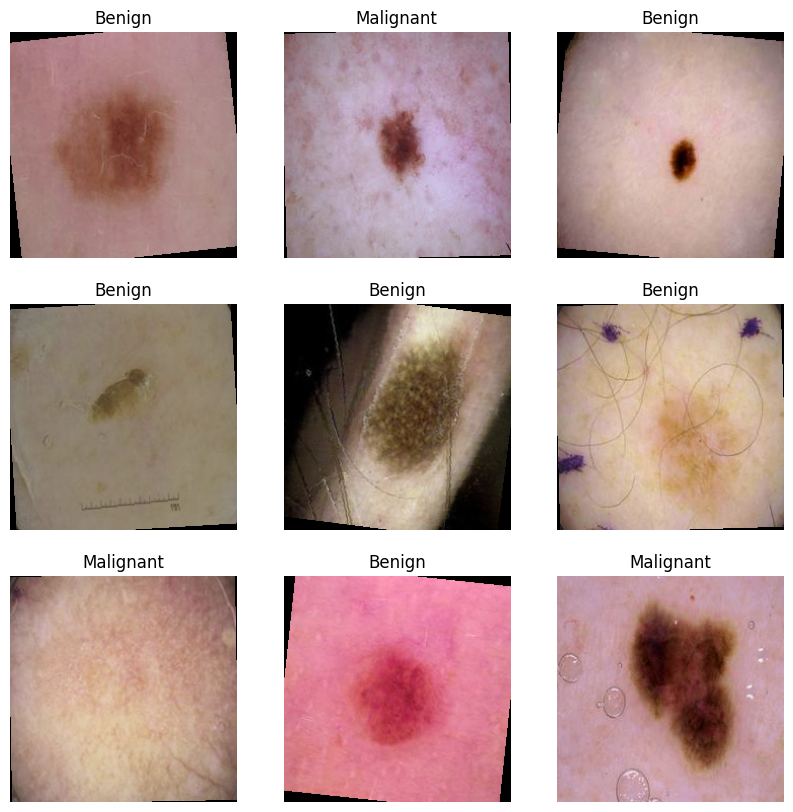

In [23]:
# ===========================
# 4️⃣ VISUALIZE TRANSFORMED IMAGES
# ===========================
def imshow_tensor(tensor, title=None):
    """Convert normalized tensor to displayable image."""
    img = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Preview a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow_tensor(images[i])
    plt.title(class_names[labels[i]])
plt.show()

In [24]:
# ===========================
# 5️⃣ CUSTOM CNN MODEL
# ===========================
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.4)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)  # logits output

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop4(x)
        logits = self.fc2(x)
        return logits  # logits only — softmax applied later



In [25]:
# ===========================
# 6️⃣ TRAINING SETUP
# ===========================
model = CustomCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(device)  # Should print mps if available, else cpu

mps


In [27]:
# ===========================
# 7️⃣ TRAINING LOOP
# ===========================
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Training Loss: {avg_loss:.4f}")


Epoch [1/30] - Training Loss: 0.4548
Epoch [2/30] - Training Loss: 0.3924
Epoch [3/30] - Training Loss: 0.3621
Epoch [4/30] - Training Loss: 0.3548
Epoch [5/30] - Training Loss: 0.3393
Epoch [6/30] - Training Loss: 0.3328
Epoch [7/30] - Training Loss: 0.3279
Epoch [8/30] - Training Loss: 0.3267
Epoch [9/30] - Training Loss: 0.3226
Epoch [10/30] - Training Loss: 0.3154
Epoch [11/30] - Training Loss: 0.3099
Epoch [12/30] - Training Loss: 0.3023
Epoch [13/30] - Training Loss: 0.2997
Epoch [14/30] - Training Loss: 0.3006
Epoch [15/30] - Training Loss: 0.2963
Epoch [16/30] - Training Loss: 0.2936
Epoch [17/30] - Training Loss: 0.2919
Epoch [18/30] - Training Loss: 0.2950
Epoch [19/30] - Training Loss: 0.2847
Epoch [20/30] - Training Loss: 0.2859
Epoch [21/30] - Training Loss: 0.2827
Epoch [22/30] - Training Loss: 0.2773
Epoch [23/30] - Training Loss: 0.2771
Epoch [24/30] - Training Loss: 0.2811
Epoch [25/30] - Training Loss: 0.2716
Epoch [26/30] - Training Loss: 0.2702
Epoch [27/30] - Train

In [28]:
!say acabaste guapo

In [29]:
# ===========================
# 8️⃣ EVALUATION ON TEST SET
# ===========================
model.eval()
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []
all_probs = []

threshold = 0.3  # <-- tune this

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of malignant
        preds = (probs > threshold).long()           # classify manually
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

acc = correct / total
print(f"\n✅ Test Accuracy: {acc:.4f}")
print(f"Test Loss: {test_loss / len(test_loader):.4f}")


✅ Test Accuracy: 0.7230
Test Loss: 0.5113


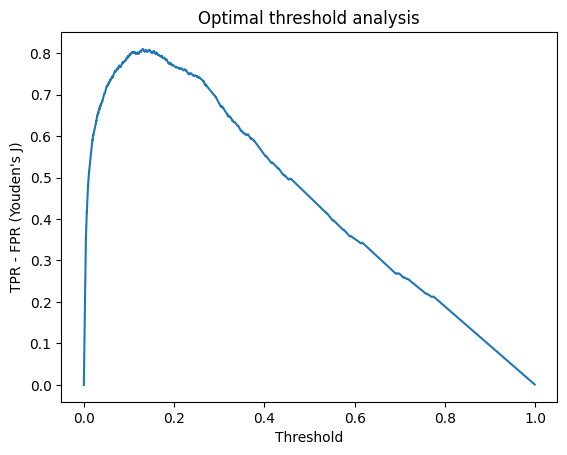

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)  # all_probs = list of model probs for class 1
plt.plot(thresholds, tpr - fpr)
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR (Youden's J)")
plt.title("Optimal threshold analysis")
plt.show()

Confusion Matrix:
[[963  37]
 [284 716]]
AUC: 0.9609


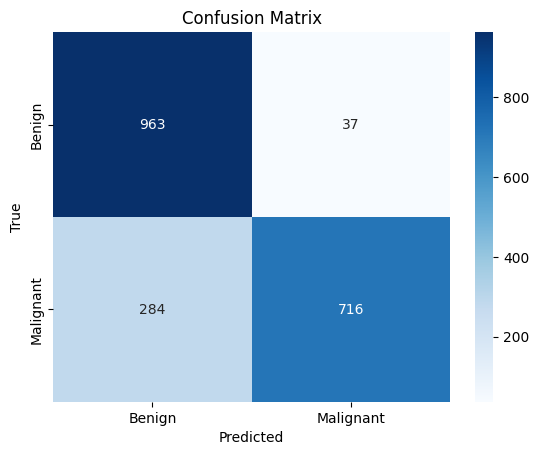

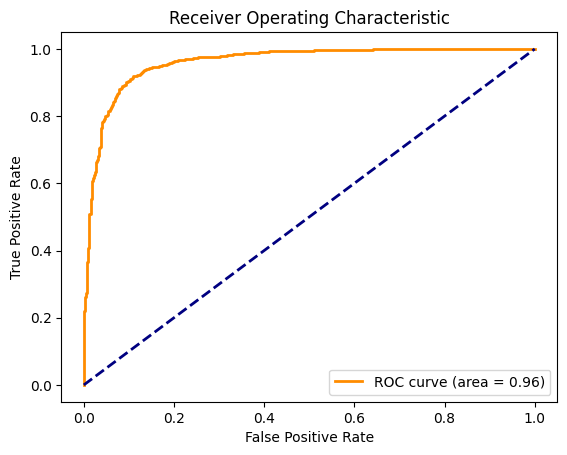

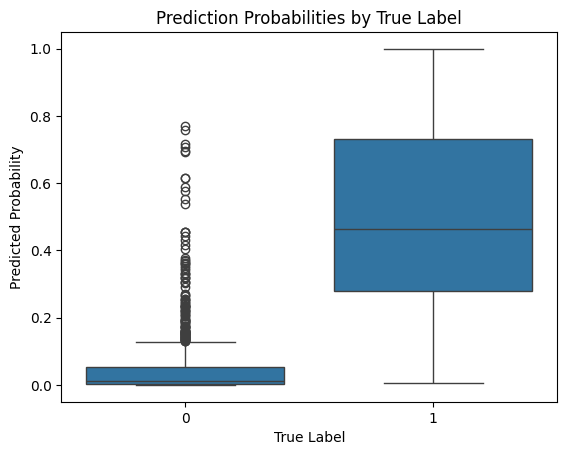

In [31]:
# 6. Metrics Calculation
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 7. AUC ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# 8. Plotting
# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Boxplot of Predictions
sns.boxplot(x=all_labels, y=all_probs)
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.title('Prediction Probabilities by True Label')
plt.show()

In [32]:
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/models/melanoma_model4.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

✅ Model saved at /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/melanoma_model3.pth
